## 데이터 로드

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import keras
from keras.layers import Dropout
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train = np.load('/content/drive/MyDrive/뉴스 분류/X_train.npy')
X_test = np.load('/content/drive/MyDrive/뉴스 분류/X_test.npy')
y_train = np.load('/content/drive/MyDrive/뉴스 분류/y_train.npy')
y_test = np.load('/content/drive/MyDrive/뉴스 분류/y_test.npy')
X_Test = np.load('/content/drive/MyDrive/뉴스 분류/X_Test.npy')  # 제출용 테스트 데이터

### Y값 원-핫-인코딩




- 참고: https://wikidocs.net/22933 (로이터 뉴스 분류하기)
- 시도해볼 모델 종류: RNN, LSTM, GRU, BiLSTM, 1D CNN(multi-kernel), CNN + LSTM,  
 BiLSTM + Attention, Transformer(self-attention), BERT, KoBERT
- tf-idf 벡터화 등 벡터화, 임베딩 방법도 여러 개 생각해보기

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# 레이블 One-hot encoding
y_train = to_categorical(y_train) # 훈련용 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 레이블의 원-핫 인코딩

In [ ]:
vocab_size = 14592  # 단어 집합의 크기 (전처리 코드 참고)

## 모델링




- **BiLSTM 기본 모델 제외한 다른 모델은 아직 안 돌려봤습니다!!**
- 참고: https://wikidocs.net/22933 (로이터 뉴스 분류하기)
- 시도해볼 모델 종류: RNN, LSTM, GRU, BiLSTM, 1D CNN(multi-kernel), CNN + LSTM,  
 BiLSTM + Attention, Transformer(self-attention), BERT, KoBERT
- tf-idf 벡터화 등 벡터화, 임베딩 방법도 여러 개 생각해보기

In [ ]:
total = pd.DataFrame(columns=['accuracy'], index=['GRU', 'LSTM','BiLSTM','BiLSTM + Attention'])

### GRU

In [ ]:
gpu_model = Sequential()
gpu_model.add(Embedding(vocab_size, 100))  # 단어들을 밀집벡터로 만드는 역할 (임베딩 벡터의 출력 차원수 = 120)
gpu_model.add(GRU(100)) # LSTM 모델 활용(은닉 상태의 크기 = 120)
gpu_model.add(Dense(7, activation='softmax'))  # 출력 뉴런 수 = 7 (7개의 카테고리)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  # 연속해서 5번 이상 검증 데이터의 손실함수가 감소하지 않으면 에폭 중단
mc = ModelCheckpoint('gpu_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)  # 검증 데이터의 acc를 기준으로 가장 우수한 모수만 저장

In [ ]:
gpu_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])  # 모델 컴파일
gpu_history = gpu_model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=80, validation_data=(X_test, y_test))  # 모델 학습

Epoch 1/15
428/428 [==============================] - 8s 13ms/step - loss: 0.8245 - acc: 0.7110 - val_loss: 0.4931 - val_acc: 0.8398

Epoch 00001: val_acc improved from -inf to 0.83980, saving model to gpu_best_model.h5
Epoch 2/15
428/428 [==============================] - 5s 12ms/step - loss: 0.3177 - acc: 0.8950 - val_loss: 0.4882 - val_acc: 0.8399

Epoch 00002: val_acc improved from 0.83980 to 0.83989, saving model to gpu_best_model.h5
Epoch 3/15
428/428 [==============================] - 7s 16ms/step - loss: 0.1942 - acc: 0.9362 - val_loss: 0.5735 - val_acc: 0.8307

Epoch 00003: val_acc did not improve from 0.83989
Epoch 4/15
428/428 [==============================] - 6s 14ms/step - loss: 0.1297 - acc: 0.9577 - val_loss: 0.6671 - val_acc: 0.8263

Epoch 00004: val_acc did not improve from 0.83989
Epoch 5/15
428/428 [==============================] - 5s 12ms/step - loss: 0.0922 - acc: 0.9689 - val_loss: 0.7448 - val_acc: 0.8180

Epoch 00005: val_acc did not improve from 0.83989
Epoch

In [ ]:
gpu_loaded_model = load_model('gpu_best_model.h5')
accuracy = gpu_loaded_model.evaluate(X_test, y_test)[1]
total['accuracy'][0] = accuracy
print("\n 테스트 정확도: %.4f" % (accuracy))

357/357 [==============================] - 2s 4ms/step - loss: 0.4882 - acc: 0.8399

 테스트 정확도: 0.8399


### LSTM

In [ ]:

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 200))  # 단어들을 밀집벡터로 만드는 역할 (임베딩 벡터의 출력 차원수 = 100)
lstm_model.add(Dropout(0.3)) 
lstm_model.add(LSTM(200))
lstm_model.add(Dense(7, activation='softmax'))  # 출력 뉴런 수 = 7 (7개의 카테고리)

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=3)  # 연속해서 5번 이상 검증 데이터의 손실함수가 감소하지 않으면 에폭 중단
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)  # 검증 데이터의 acc를 기준으로 가장 우수한 모수만 저장

In [ ]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])  # 모델 컴파일
lstm_history=lstm_model.fit(X_train, y_train, epochs=15, batch_size=80, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/15
428/428 [==============================] - 5s 7ms/step - loss: 0.7841 - acc: 0.7280 - val_loss: 0.4744 - val_acc: 0.8424

Epoch 00001: val_loss improved from inf to 0.47437, saving model to best_model.h5
Epoch 2/15
428/428 [==============================] - 3s 7ms/step - loss: 0.3168 - acc: 0.8952 - val_loss: 0.4704 - val_acc: 0.8466

Epoch 00002: val_loss improved from 0.47437 to 0.47043, saving model to best_model.h5
Epoch 3/15
428/428 [==============================] - 3s 7ms/step - loss: 0.2035 - acc: 0.9306 - val_loss: 0.5441 - val_acc: 0.8329

Epoch 00003: val_loss did not improve from 0.47043
Epoch 4/15
428/428 [==============================] - 3s 6ms/step - loss: 0.1426 - acc: 0.9526 - val_loss: 0.6244 - val_acc: 0.8308

Epoch 00004: val_loss did not improve from 0.47043
Epoch 5/15
428/428 [==============================] - 3s 6ms/step - loss: 0.1066 - acc: 0.9628 - val_loss: 0.6833 - val_acc: 0.8259

Epoch 00005: val_loss did not improve from 0.47043
Epoch 00005: e

In [ ]:
lstm_loaded_model = load_model('best_model.h5')
accuracy = lstm_loaded_model.evaluate(X_test, y_test)[1]
total['accuracy'][1] = accuracy
print("\n 테스트 정확도: %.4f" % (accuracy))

357/357 [==============================] - 1s 3ms/step - loss: 0.4704 - acc: 0.8466

 테스트 정확도: 0.8466


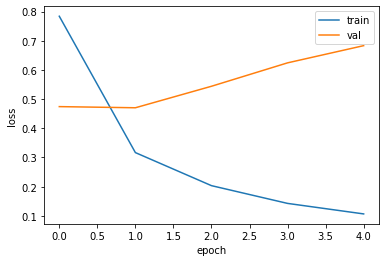

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### LSTM 2

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [ ]:
es_2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  # 연속해서 5번 이상 검증 데이터의 손실함수가 감소하지 않으면 에폭 중단
mc_2 = ModelCheckpoint('lstm_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)  # 검증 데이터의 acc를 기준으로 가장 우수한 모수만 저장

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])  # 모델 컴파일
history=model.fit(X_train, y_train, epochs=15, batch_size=80, validation_data=(X_test, y_test), callbacks=[es_2, mc_2])

Epoch 1/15
428/428 [==============================] - 20s 35ms/step - loss: 0.9145 - acc: 0.6565 - val_loss: 0.5233 - val_acc: 0.8274

Epoch 00001: val_acc improved from -inf to 0.82736, saving model to lstm_best_model.h5
Epoch 2/15
428/428 [==============================] - 14s 33ms/step - loss: 0.3741 - acc: 0.8801 - val_loss: 0.5134 - val_acc: 0.8381

Epoch 00002: val_acc improved from 0.82736 to 0.83814, saving model to lstm_best_model.h5
Epoch 3/15
428/428 [==============================] - 13s 31ms/step - loss: 0.2519 - acc: 0.9198 - val_loss: 0.5465 - val_acc: 0.8302

Epoch 00003: val_acc did not improve from 0.83814
Epoch 4/15
428/428 [==============================] - 13s 31ms/step - loss: 0.1861 - acc: 0.9392 - val_loss: 0.6348 - val_acc: 0.8268

Epoch 00004: val_acc did not improve from 0.83814
Epoch 5/15
428/428 [==============================] - 14s 32ms/step - loss: 0.1471 - acc: 0.9528 - val_loss: 0.7189 - val_acc: 0.8162

Epoch 00005: val_acc did not improve from 0.8381

In [ ]:
loaded_model = load_model('lstm_best_model.h5')
accuracy = loaded_model.evaluate(X_test, y_test)[1]
total['accuracy'][1] = accuracy
print("\n 테스트 정확도: %.4f" % (accuracy))

357/357 [==============================] - 6s 13ms/step - loss: 0.5134 - acc: 0.8381

 테스트 정확도: 0.8381


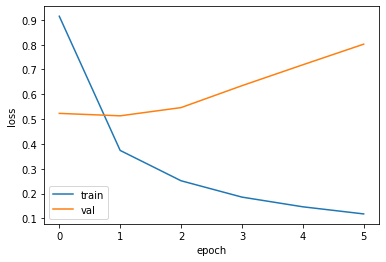

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### BiLSTM

In [ ]:
from keras.layers import Dropout

In [ ]:
BiLSTM_model = Sequential()
BiLSTM_model.add(Embedding(vocab_size, 100))  # 단어들을 밀집벡터로 만드는 역할 (임베딩 벡터의 출력 차원수 = 100)
BiLSTM_model.add(Bidirectional(LSTM(512,return_sequences=True)))
BiLSTM_model.add(Dropout(0.4))
BiLSTM_model.add(Bidirectional(LSTM(256,return_sequences=True)))
BiLSTM_model.add(Dropout(0.4))
BiLSTM_model.add(Bidirectional(LSTM(128)))
BiLSTM_model.add(Dense(128))
BiLSTM_model.add(Dropout(0.4))
BiLSTM_model.add(Dense(7, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)  # 연속해서 5번 이상 검증 데이터의 손실함수가 감소하지 않으면 에폭 중단
mc = ModelCheckpoint('bi-lstm_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)  # 검증 데이터의 acc를 기준으로 가장 우수한 모수만 저장

In [ ]:
BiLSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])  # 모델 컴파일
history=BiLSTM_model.fit(X_train, y_train, epochs=15, batch_size=80, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/15
428/428 [==============================] - 46s 84ms/step - loss: 0.8019 - acc: 0.7118 - val_loss: 0.5232 - val_acc: 0.8259

Epoch 00001: val_acc improved from -inf to 0.82587, saving model to bi-lstm_best_model.h5
Epoch 2/15
428/428 [==============================] - 33s 77ms/step - loss: 0.3661 - acc: 0.8805 - val_loss: 0.5579 - val_acc: 0.8273

Epoch 00002: val_acc improved from 0.82587 to 0.82727, saving model to bi-lstm_best_model.h5
Epoch 3/15
428/428 [==============================] - 33s 78ms/step - loss: 0.2509 - acc: 0.9216 - val_loss: 0.5832 - val_acc: 0.8212

Epoch 00003: val_acc did not improve from 0.82727
Epoch 4/15
428/428 [==============================] - 33s 78ms/step - loss: 0.1908 - acc: 0.9395 - val_loss: 0.6476 - val_acc: 0.8201

Epoch 00004: val_acc did not improve from 0.82727
Epoch 5/15
428/428 [==============================] - 33s 77ms/step - loss: 0.1467 - acc: 0.9521 - val_loss: 0.7423 - val_acc: 0.8147

Epoch 00005: val_acc did not improve from 

In [ ]:
BILSTM_loaded_model = load_model('bi-lstm_best_model.h5')
accuracy = BILSTM_loaded_model.evaluate(X_test, y_test)[1]
total['accuracy'][2] = accuracy
print("\n 테스트 정확도: %.4f" % (accuracy))

357/357 [==============================] - 13s 29ms/step - loss: 0.5579 - acc: 0.8273

 테스트 정확도: 0.8273


### BiLSTM + Attention
- 참고: https://wikidocs.net/48920 
- keras의 functional API 활용 (참고: https://wikidocs.net/38861)

- 바다나우 어텐션 함수

In [ ]:
import tensorflow as tf

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

- 양방향 LSTM + 바다나우 어텐션

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
max_len = 16  # 최대 길이 16으로 패딩함 (전처리 코드 참고)

In [ ]:
sequence_input = Input(shape=(max_len,), dtype='int32')  # 입력층
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)  # 임베딩 층

In [ ]:
# 양방향 LSTM 2층 쌓기
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [ ]:
# 각 상태의 크기 출력
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 16, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [ ]:
# 순방향 LSTM과 역방향 LSTM의 상태 연결
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
# 어텐션 메커니즘: 은닉상태 사용, 컨텍스트 벡터 얻음
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [ ]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(7, activation="softmax")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  # 연속해서 5번 이상 검증 데이터의 손실함수가 감소하지 않으면 에폭 중단
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)  # 검증 데이터의 acc를 기준으로 가장 우수한 모수만 저장

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 모델 컴파일
history = model.fit(X_train, y_train, epochs = 15, callbacks=[es, mc], batch_size = 256, validation_split=0.2)

Epoch 1/15
107/107 [==============================] - 60s 376ms/step - loss: 1.5585 - accuracy: 0.3619 - val_loss: 1.0123 - val_accuracy: 0.6521
Epoch 2/15
107/107 [==============================] - 34s 322ms/step - loss: 0.9294 - accuracy: 0.6722 - val_loss: 0.7114 - val_accuracy: 0.7870
Epoch 3/15
107/107 [==============================] - 34s 320ms/step - loss: 0.6690 - accuracy: 0.7929 - val_loss: 0.6191 - val_accuracy: 0.8190
Epoch 4/15
107/107 [==============================] - 35s 324ms/step - loss: 0.5167 - accuracy: 0.8471 - val_loss: 0.6183 - val_accuracy: 0.8249
Epoch 5/15
107/107 [==============================] - 34s 319ms/step - loss: 0.4298 - accuracy: 0.8748 - val_loss: 0.6474 - val_accuracy: 0.8240
Epoch 6/15
107/107 [==============================] - 34s 316ms/step - loss: 0.3570 - accuracy: 0.8977 - val_loss: 0.6990 - val_accuracy: 0.8271
Epoch 7/15
107/107 [==============================] - 34s 321ms/step - loss: 0.3235 - accuracy: 0.9069 - val_loss: 0.7210 - val_ac

In [ ]:
attention_loaded_model = load_model('best_model.h5')
accuracy = attention_loaded_model.evaluate(X_test, y_test)[1]
total['accuracy'][3] = accuracy
print("\n 테스트 정확도: %.4f" % (accuracy))

357/357 [==============================] - 2s 5ms/step - loss: 0.5922 - acc: 0.8229

 테스트 정확도: 0.8229


## 실제 테스트 데이터 전처리 및 분류하기
- GRU, LSTM, BiLSTM, Attention_bi_lstm 모델의 best model 적용 -> 확률 기반 앙상블

In [ ]:
y_predicted_0 = gpu_loaded_model.predict(X_Test) #gru
y_predicted_1 = loaded_model.predict(X_Test) #lstm
y_predicted_2 = BILSTM_loaded_model.predict(X_Test)
y_predicted_3 = attention_loaded_model.predict(X_Test)

In [ ]:
len(y_predicted_0)

9131

In [ ]:
len(y_predicted_1)

9131

In [ ]:
y_predicted=y_predicted_0+y_predicted_1+y_predicted_2+y_predicted_3

In [ ]:
y_predicted

array([[3.0914676e-01, 1.6002579e-01, 1.9845570e+00, ..., 1.5693169e-02,
        3.0351670e-03, 1.4310813e-02],
       [1.5335877e-03, 3.4693704e-04, 4.7833538e-03, ..., 5.2970275e-04,
        1.4233373e-03, 1.4825692e-04],
       [2.9707050e-01, 1.1006049e-01, 2.8359458e+00, ..., 7.1519196e-02,
        2.6257614e-02, 6.1158907e-01],
       ...,
       [2.1161568e-01, 2.2268852e-02, 1.8025734e+00, ..., 2.4602478e-02,
        1.3707418e-02, 7.9901591e-03],
       [2.7698212e+00, 4.9272415e-01, 6.7724645e-01, ..., 2.4609797e-02,
        4.7645564e-03, 2.0437751e-02],
       [5.8893476e-02, 5.1320091e-02, 2.2921877e+00, ..., 1.8502671e-02,
        3.2014498e-03, 1.5669694e+00]], dtype=float32)

In [ ]:
y_predicted = y_predicted.argmax(axis=-1)# 예측된 정수 시퀀스로 변환

In [ ]:
y_predicted

array([2, 3, 2, ..., 3, 0, 2])

In [ ]:
Test_data=pd.read_csv('/content/drive/MyDrive/뉴스 분류/test_data.csv')

In [ ]:
Test_data['topic_idx'] = y_predicted

In [ ]:
del Test_data['title']

In [ ]:
len(Test_data)

9131

In [ ]:
# to_csv 저장
Test_data.to_csv('/content/drive/MyDrive/뉴스 분류/무성_제출파일_앙상블 두번째.csv', index=None)

In [ ]:
total

,accuracy
GRU,0.839891
LSTM,0.838139
BiLSTM,0.827272
BiLSTM + Attention,0.82289
